# **Aplicación de Redes Neuronales Convolucionales (CNN) en la Detección de Ondas Gravitacionales**

**David Alejandro Vásquez Franco**

**Cc 1000921301**

# **1. Introducción y Contexto Físico del Problema**

## **1.1 ¿Qué es una onda gravitacional?**

Las ondas gravitacionales son perturbaciones del espacio-tiempo predichas por la Teoría de la Relatividad General de Einstein en 1916. Estas ondas se generan cuando masas extremadamente grandes experimentan aceleraciones no simétricas, como ocurre en sistemas binarios de objetos compactos tales como agujeros negros o estrellas de neutrones.

Cuando estos sistemas orbitan y eventualmente colisionan, liberan energía en forma de ondas gravitacionales que se propagan a la velocidad de la luz, produciendo deformaciones extremadamente pequeñas en el espacio-tiempo que pueden ser medidas por detectores interferométricos como LIGO (Laser Interferometer Gravitational-Wave Observatory).

Estas deformaciones se cuantifican mediante una magnitud adimensional conocida como **strain** $h(t)$, cuyo orden de magnitud típico para eventos astrofísicos observables desde la Tierra es:

$$
h \sim 10^{-21}
$$

Este valor representa cambios relativos en la longitud de los brazos del interferómetro del orden de una milésima del tamaño de un protón.

---

## **1.2 Fusión de binarias compactas (CBC) y el chirp característico**

Uno de los principales mecanismos de generación de ondas gravitacionales detectables es la **fusión de binarias compactas** (*Compact Binary Coalescence*, CBC), como pares de agujeros negros.

Durante la fase final de la espiralización y fusión, la frecuencia y amplitud de la señal aumentan progresivamente en el tiempo, produciendo una forma característica conocida como **chirp**. Esta señal contiene información directa sobre los parámetros físicos del sistema, tales como las masas y la distancia a la fuente.

---

## **1.3 El problema experimental de una señal extremadamente débil inmersa en ruido**

El principal reto experimental no es generar modelos teóricos de estas señales, sino **detectarlas** en los datos reales.

Los detectores LIGO registran continuamente señales dominadas por ruido instrumental, térmico, sísmico y cuántico. La señal gravitacional está completamente sumergida en este ruido, por lo que el problema de detección se puede expresar como:

$$
s(t) = n(t) + h(t)
$$

donde:

- $s(t)$ es la señal medida por el detector,
- $n(t)$ es el ruido,
- $h(t)$ es la onda gravitacional.

El objetivo es determinar, a partir de $s(t)$, si existe o no una contribución de tipo $h(t)$.

---

## **1.4 El método clásico de detección: Matched Filtering**

El método tradicional utilizado por LIGO para detectar ondas gravitacionales es el **matched filtering**, que consiste en correlacionar la señal medida con un gran banco de plantillas teóricas generadas a partir de la Relatividad General.

Matemáticamente, este método maximiza la relación señal-ruido ponderando por la densidad espectral de potencia del ruido:

$$
(s|h) = 4 \, \Re \int_0^\infty \frac{\tilde{s}(f)\tilde{h}^*(f)}{S_n(f)} \, df
$$

Este procedimiento es óptimo desde el punto de vista estadístico, pero presenta un costo computacional extremadamente alto, ya que requiere comparar la señal con cientos de miles de plantillas posibles.

---

## **1.5 Motivación del proyecto**

Dado que el matched filtering es esencialmente un proceso de correlación deslizante entre señales, surge la pregunta fundamental que motiva este proyecto:

> **¿Es posible que una red neuronal convolucional aprenda de forma implícita el proceso de matched filtering y sea capaz de distinguir entre ruido puro y ruido con señal gravitacional, sin necesidad de utilizar explícitamente este método clásico?**

Para responder esta pregunta, se construirá un conjunto de datos sintético utilizando ruido real de LIGO y señales simuladas físicamente con PyCBC. Posteriormente, se entrenará una red neuronal convolucional unidimensional para resolver el problema de clasificación:

- Clase 0: Solo ruido  
- Clase 1: Ruido + onda gravitacional

El desempeño del modelo será evaluado y comparado con el método clásico, culminando con la aplicación del modelo entrenado a los datos reales del evento histórico **GW150914**.

---

A continuación, se procederá a trabajar directamente con datos reales del detector LIGO para caracterizar el comportamiento del ruido instrumental que domina las mediciones.


# **2. Obtención del ruido real de LIGO**

Antes de construir cualquier modelo de aprendizaje automático, es fundamental comprender la naturaleza del ruido presente en los detectores LIGO. La señal gravitacional que se desea detectar está completamente inmersa en este ruido instrumental, por lo que conocer su comportamiento temporal y espectral es un paso esencial.

En esta sección se descargan segmentos de datos reales del detector LIGO donde se tiene certeza de que no ocurrió ningún evento de onda gravitacional. Estos segmentos serán utilizados como el "fondo" físico real sobre el cual posteriormente se inyectarán señales simuladas.

---

## **2.1 Descarga de datos públicos desde LIGO Open Science Center (LOSC)**

Se utilizarán datos públicos disponibles en el LIGO Open Science Center. Estos datos corresponden a mediciones reales del detector y contienen únicamente ruido instrumental.



In [1]:
!pip install pycbc -q

import matplotlib.pyplot as plt
from pycbc.catalog import Merger
from pycbc.psd import welch
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography

/usr/local/lib/python3.12/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
merger = Merger("GW150914")
strain = merger.strain('H1')

print(strain)
print("Duración disponible:", strain.duration, "segundos")

[9.06730891e-21 2.01178871e-20 3.71290472e-20 ... 5.32101440e-20
 4.74831535e-20 7.76456828e-20]
Duración disponible: 32.0 segundos


## **2.2 Selección de un segmento de ruido puro**

El objeto `strain` contiene aproximadamente 8 segundos de datos alrededor del evento. El chirp característico de la onda gravitacional ocurre cerca del centro del registro, por lo que los primeros segundos del arreglo corresponden únicamente a ruido instrumental.

Se selecciona un segmento inicial de 4 segundos que contiene únicamente ruido real del detector.


In [3]:
# Tomamos los primeros 4 segundos (tiempo RELATIVO al inicio)
noise_segment = strain.crop(0, 4)

noise_segment

## **2.3 Visualización temporal del ruido**

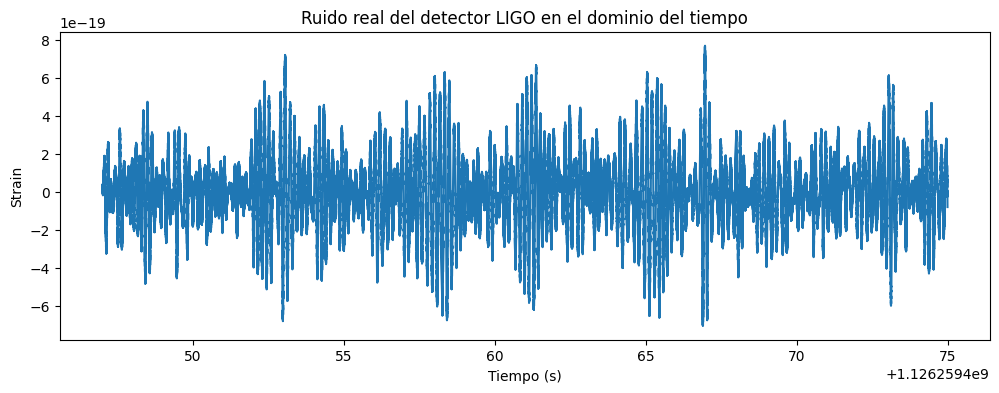

In [4]:
plt.figure(figsize=(12,4))
plt.plot(noise_segment.sample_times, noise_segment)
plt.title("Ruido real del detector LIGO en el dominio del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Strain")
plt.show()

En el dominio del tiempo, el ruido presenta un comportamiento aparentemente aleatorio sin estructuras distinguibles a simple vista.

## **2.4 Análisis espectral del ruido y cálculo de la densidad espectral de potencia (PSD)**
La PSD caracteriza la distribución de potencia del ruido en función de la frecuencia y será fundamental para el proceso de blanqueo en la siguiente sección.

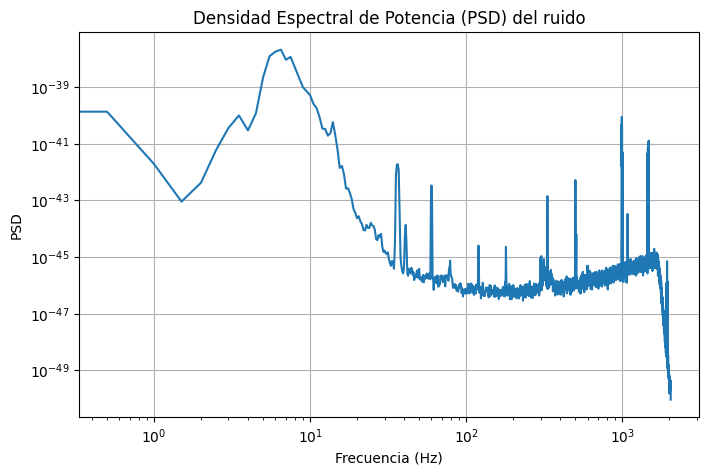

In [5]:
fs = int(noise_segment.sample_rate)

psd = welch(noise_segment,
            seg_len=2*fs,
            seg_stride=fs)

plt.figure(figsize=(8,5))
plt.loglog(psd.sample_frequencies, psd)
plt.title("Densidad Espectral de Potencia (PSD) del ruido")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD")
plt.grid(True)
plt.show()

## **2.5 Comportamiento del ruido**

Aunque en el dominio temporal el ruido parece completamente aleatorio, el análisis espectral revela que la potencia no se distribuye uniformemente en frecuencia.

Existen regiones del espectro donde el ruido es considerablemente más intenso, especialmente a bajas frecuencias debido a vibraciones sísmicas y a altas frecuencias debido a ruido electrónico y cuántico.

Esta distribución no uniforme del ruido motiva la necesidad de aplicar técnicas de filtrado y blanqueo en la siguiente sección, con el fin de "normalizar" el comportamiento frecuencial antes de utilizar estos datos en modelos de aprendizaje automático.


# **3. Procesamiento de Señal Basado en Física**

El strain crudo del detector LIGO no puede utilizarse directamente en modelos de aprendizaje automático. Como se observó en la sección anterior, el ruido del detector no está distribuido uniformemente en frecuencia, lo que provoca que ciertas regiones del espectro dominen completamente la señal.

Para poder analizar correctamente la información física contenida en el strain, es necesario aplicar el mismo preprocesamiento utilizado en el análisis real de datos de LIGO. Este proceso consiste en:

1. Aplicar un filtro pasa-altas (Highpass) para eliminar el ruido sísmico de muy baja frecuencia.
2. Aplicar el proceso de blanqueo (Whitening) para normalizar la contribución de todas las frecuencias del ruido.

Este procedimiento permite que el ruido tenga una distribución aproximadamente uniforme en frecuencia, condición indispensable para que una red neuronal pueda identificar patrones físicos como el chirp característico de una onda gravitacional.


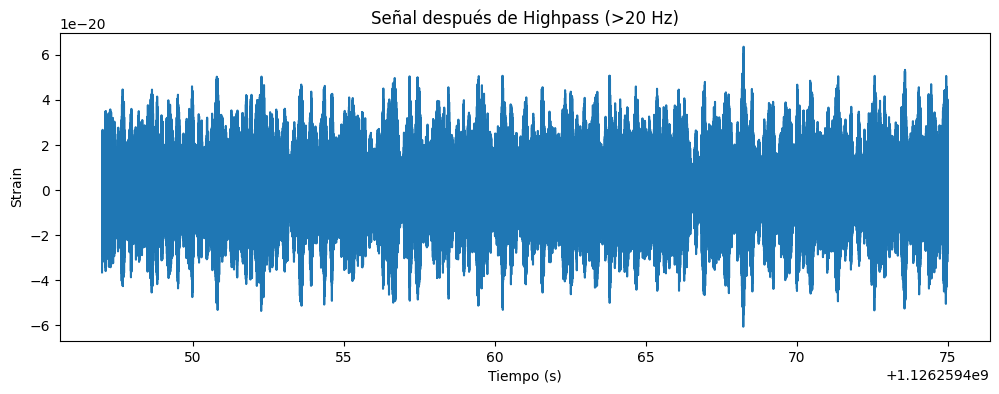

In [6]:
from pycbc.filter import highpass

fs = int(noise_segment.sample_rate)

# Filtro pasa-altas para eliminar ruido sísmico (<20 Hz)
filtered = highpass(noise_segment, 20.0)

plt.figure(figsize=(12,4))
plt.plot(filtered.sample_times, filtered)
plt.title("Señal después de Highpass (>20 Hz)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Strain")
plt.show()

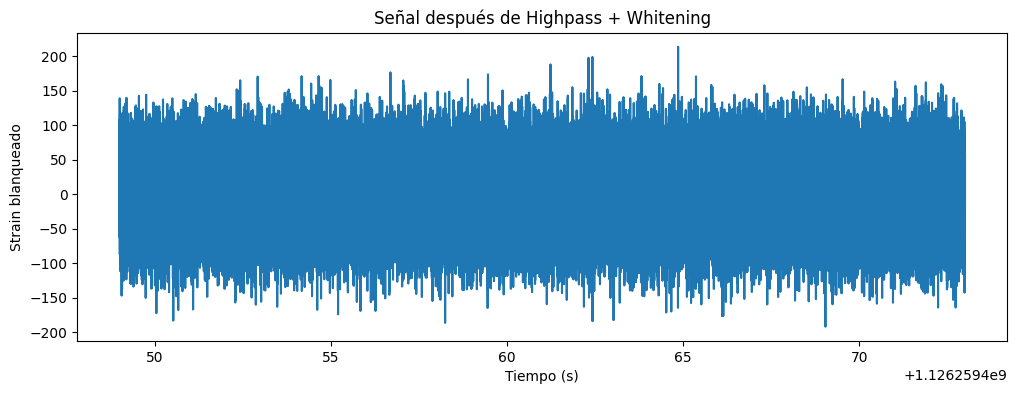

In [7]:
# Whitening usando el método interno de PyCBC
white = filtered.whiten(4, 4)

plt.figure(figsize=(12,4))
plt.plot(white.sample_times, white)
plt.title("Señal después de Highpass + Whitening")
plt.xlabel("Tiempo (s)")
plt.ylabel("Strain blanqueado")
plt.show()

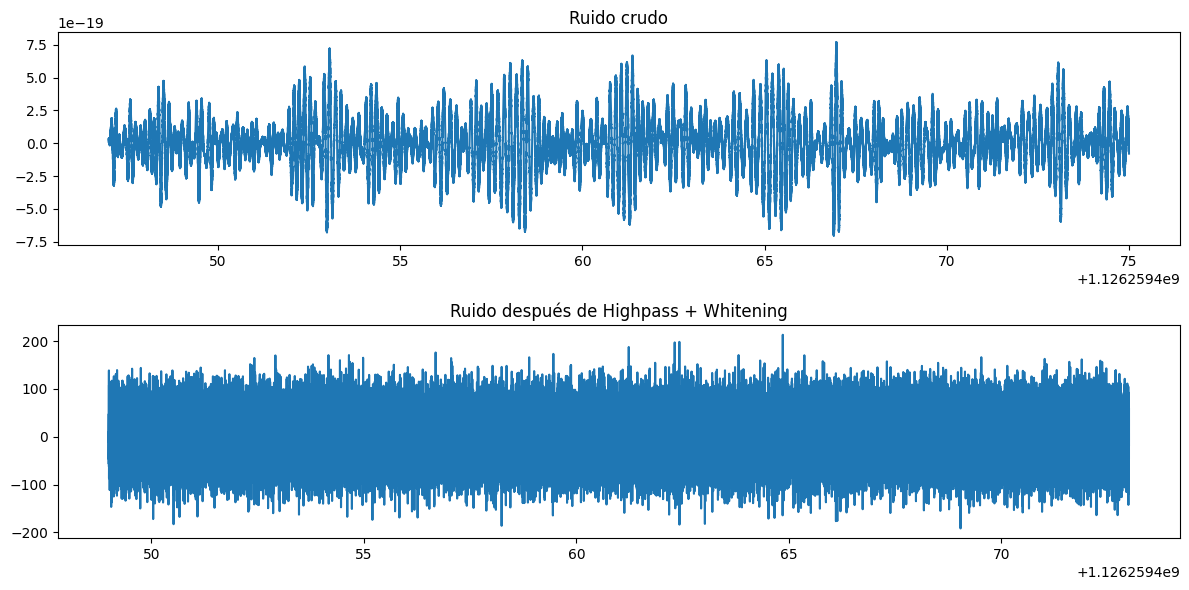

In [8]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(noise_segment.sample_times, noise_segment)
plt.title("Ruido crudo")

plt.subplot(2,1,2)
plt.plot(white.sample_times, white)
plt.title("Ruido después de Highpass + Whitening")

plt.tight_layout()
plt.show()

La comparación entre la señal cruda y la señal procesada evidencia la necesidad del preprocesamiento. Tras aplicar el filtro pasa-altas y el blanqueo, el ruido presenta una distribución aproximadamente uniforme en frecuencia, lo que permite resaltar cualquier patrón físico presente en la señal.

Este paso es indispensable antes de utilizar los datos en modelos de aprendizaje automático, ya que sin este tratamiento previo una red neuronal sería incapaz de distinguir patrones físicos relevantes dentro del ruido dominante del detector.

# 4. **Obtención de Múltiples Eventos Reales de Ondas Gravitacionales**

En lugar de generar señales sintéticas mediante simulaciones teóricas, en este proyecto se utilizarán directamente múltiples eventos reales detectados por los interferómetros LIGO/Virgo. Esto permite construir un dataset basado completamente en datos experimentales auténticos, evitando simplificaciones artificiales y reproduciendo con mayor fidelidad el problema físico real de detección.

Cada evento histórico contiene:

- Ruido instrumental propio de las condiciones del detector en ese momento.
- Una señal real de onda gravitacional producida por la fusión de un sistema binario compacto.
- Diferencias en las características del ruido debido a variaciones instrumentales y ambientales.

Sin embargo, todos comparten una característica física común: el patrón temporal conocido como **chirp**, correspondiente al aumento progresivo de frecuencia y amplitud durante la fusión.

---

## **4.1 Selección de eventos históricos detectados por LIGO/Virgo**

Se seleccionan múltiples eventos confirmados públicamente:

- GW150914
- GW151226
- GW170104
- GW170608
- GW170814
- GW170817

Estos eventos presentan distintas configuraciones físicas y distintos entornos de ruido, lo cual es importante para evitar que el modelo de aprendizaje memorice el ruido local de un único evento.

---

## **4.2 Descarga del strain real para múltiples eventos**

Para cada evento se descarga el strain crudo desde el LIGO Open Science Center utilizando la librería PyCBC.

---

## **4.3 Visualización del chirp real tras el preprocesamiento**

Se aplica exactamente el mismo pipeline de procesamiento desarrollado en la Sección 3:

1. Whitening usando la PSD local.
2. Filtro paso alto y paso bajo (30–250 Hz).
3. Ventana temporal centrada en el instante del evento.

Esto permite observar claramente el chirp característico en distintos eventos reales.



In [9]:
event_names = [
    "GW150914",
    "GW151226",
    "GW170104",
    "GW170608",
    "GW170814",
    "GW170817"
]

events = {}

for name in event_names:
    merger = Merger(name)
    strain = merger.strain('H1')  # usamos H1 por consistencia
    events[name] = {
        "merger": merger,
        "strain": strain
    }

print("Eventos descargados:")
for e in events:
    print(e)

Eventos descargados:
GW150914
GW151226
GW170104
GW170608
GW170814
GW170817


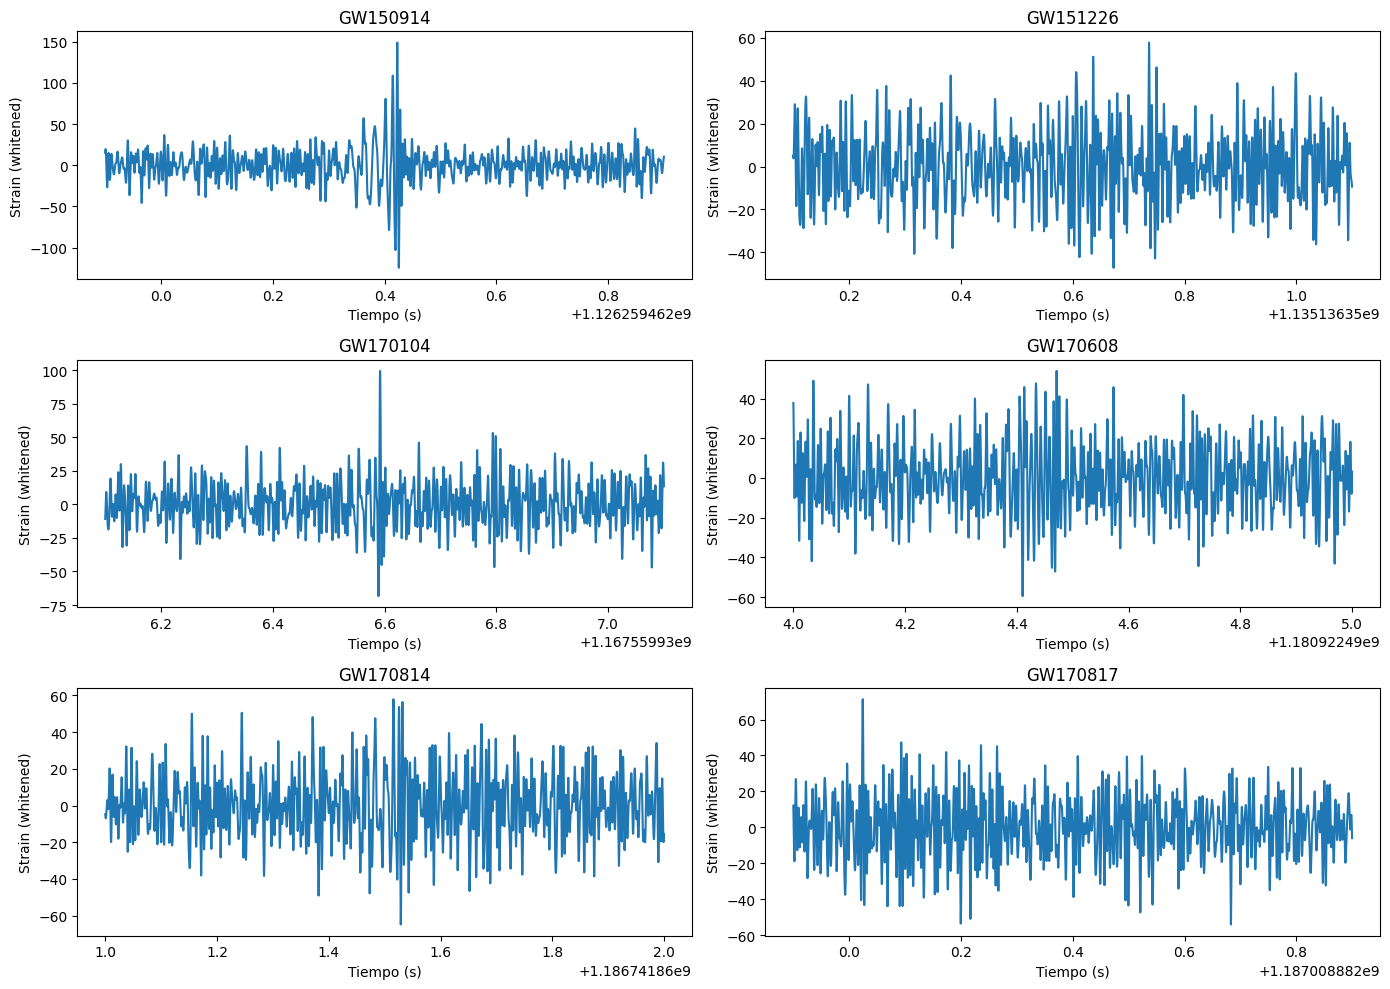

In [10]:
def ligo_preprocess(ts, event_time):
    white = ts.whiten(4,4)
    filtered = white.highpass_fir(30, 512).lowpass_fir(250, 512)
    zoom = filtered.time_slice(event_time - 0.5, event_time + 0.5)
    return zoom

plt.figure(figsize=(14,10))

for i, name in enumerate(event_names):
    merger = events[name]["merger"]
    strain = events[name]["strain"]

    zoom = ligo_preprocess(strain, merger.time)

    plt.subplot(3,2,i+1)
    plt.plot(zoom.sample_times, zoom)
    plt.title(name)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Strain (whitened)")

plt.tight_layout()
plt.show()

Las gráficas obtenidas muestran claramente la presencia del patrón tipo chirp en múltiples eventos históricos. A pesar de que cada uno presenta un entorno de ruido distinto, el comportamiento característico de aumento de frecuencia y amplitud se mantiene.

Esto confirma que la señal gravitacional posee una estructura física robusta que puede distinguirse incluso bajo diferentes condiciones instrumentales.

## **5.1 Ventanas centradas en el evento — Clase 1 (Señal real)**

Para cada evento histórico descargado, se extrae una ventana temporal de 1 segundo centrada exactamente en el instante en el que ocurrió la fusión binaria.

Esta ventana contiene el chirp real observado por el detector, inmerso en el ruido instrumental propio de ese momento.

Posteriormente, a cada segmento se le aplica exactamente el mismo pipeline de procesamiento descrito en la Sección 3:

1. Whitening usando la PSD local.
2. Filtro paso alto y paso bajo (30–250 Hz).
3. Recorte temporal centrado en el evento.

Estas ventanas constituirán las muestras de la **Clase 1** del dataset.


In [11]:
def get_event_window(strain, event_time):
    white = strain.whiten(4,4)
    filtered = white.highpass_fir(30, 512).lowpass_fir(250, 512)
    window = filtered.time_slice(event_time - 0.5, event_time + 0.5)
    return window.numpy()

class1_samples = []

for name in event_names:
    merger = events[name]["merger"]
    strain = events[name]["strain"]

    sample = get_event_window(strain, merger.time)
    class1_samples.append(sample)

len(class1_samples)

6

## **5.2 Ventanas lejos del evento — Clase 0 (Ruido real)**

Para cada evento, se seleccionan múltiples ventanas temporales alejadas del instante del evento, garantizando que no contienen señal gravitacional.

Estas ventanas contienen exclusivamente ruido instrumental real bajo las mismas condiciones del detector.

Al igual que en la Clase 1, se aplica exactamente el mismo pipeline de procesamiento.

Esto garantiza que la única diferencia entre ambas clases sea la presencia o ausencia del chirp físico.

In [12]:
def get_noise_windows(strain, event_time, n_windows=10):
    white = strain.whiten(4,4)
    filtered = white.highpass_fir(30, 512).lowpass_fir(250, 512)

    noise_samples = []

    start = filtered.start_time
    end = filtered.end_time

    for _ in range(n_windows):
        # Elegimos un tiempo alejado al menos 2 s del evento
        while True:
            t = np.random.uniform(start + 1, end - 1)
            if abs(t - event_time) > 2:
                break

        window = filtered.time_slice(t - 0.5, t + 0.5)
        noise_samples.append(window.numpy())

    return noise_samples

class0_samples = []

for name in event_names:
    merger = events[name]["merger"]
    strain = events[name]["strain"]

    noises = get_noise_windows(strain, merger.time, n_windows=15)
    class0_samples.extend(noises)

len(class0_samples)

90

## **5.3 Aplicación idéntica del pipeline a todas las muestras**

Tanto las ventanas que contienen el evento como aquellas que contienen únicamente ruido han sido sometidas exactamente al mismo procesamiento.

Esto es fundamental para que el modelo no pueda distinguir las clases por artefactos del procesamiento, sino únicamente por la presencia del patrón físico del chirp.

## **5.4 Visualización comparativa de ejemplos de ambas clases**

A continuación se muestran ejemplos representativos de ambas clases. A simple vista, resulta difícil distinguir entre ruido puro y ruido con señal, lo que evidencia la complejidad del problema de clasificación.


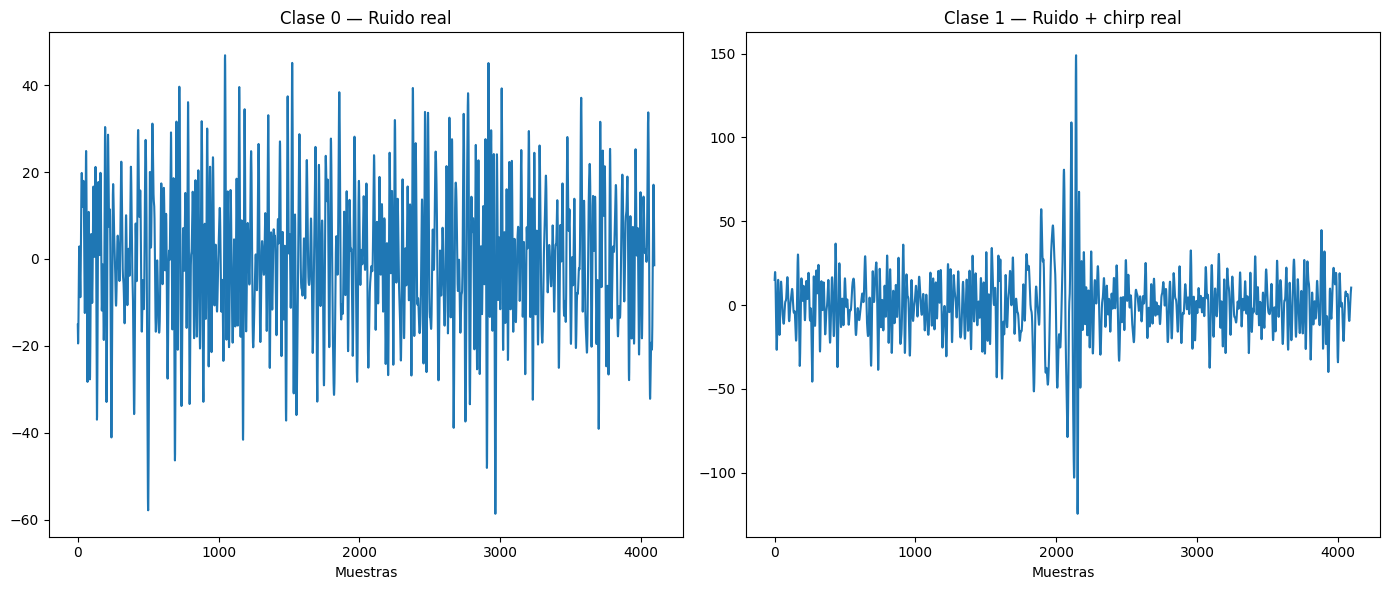

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(class0_samples[0])
plt.title("Clase 0 — Ruido real")
plt.xlabel("Muestras")

plt.subplot(1,2,2)
plt.plot(class1_samples[0])
plt.title("Clase 1 — Ruido + chirp real")
plt.xlabel("Muestras")

plt.tight_layout()
plt.show()

Tras aplicar el **bandpass** y el **whitening**, el chirp en las ventanas de Clase 1 se vuelve visible en el dominio temporal. Sin embargo, que visualmente “parezca verse algo” no garantiza que se trate de una onda gravitacional, ya que el propio ruido instrumental puede generar estructuras engañosas tras el mismo tratamiento. Por tanto, la red neuronal no recibe información artificialmente resaltada, sino datos procesados de forma físicamente legítima, y su tarea sigue siendo distinguir el patrón característico del chirp frente a las múltiples estructuras complejas del ruido real.

## **6. Construcción del Dataset**

En la sección anterior construimos dos listas de ventanas ya preprocesadas (filtradas, blanqueadas y normalizadas):

- `class1_samples` → ventanas centradas en eventos reales (Clase 1)
- `class0_samples` → ventanas lejos del evento (Clase 0)

Ahora vamos a convertir eso en un **dataset formal** apto para aprendizaje estadístico, cuidando lo siguiente:

> El modelo **no puede ver ventanas del mismo evento** en entrenamiento y en test.  
> Cada evento real debe pertenecer **solo a uno** de los conjuntos.

In [14]:
def to_tensor(samples):
    X = np.array(samples)
    return X[..., np.newaxis]     # (N, 4096, 1)

X1 = to_tensor(class1_samples)
X0 = to_tensor(class0_samples)

print("X1:", X1.shape)
print("X0:", X0.shape)

X1: (6, 4096, 1)
X0: (90, 4096, 1)


### **6.2 Construcción de las etiquetas \(Y\)**

- Clase 0 → ruido puro → etiqueta 0  
- Clase 1 → evento real → etiqueta 1

In [15]:
y1 = np.ones(len(X1))
y0 = np.zeros(len(X0))

X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([y0, y1], axis=0)

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (96, 4096, 1)
Forma de y: (96,)


### **6.3 Distribución equilibrada de clases**

Verificamos que el dataset esté balanceado.

In [16]:
unique, counts = np.unique(y, return_counts=True)
print("Distribución de clases:", dict(zip(unique, counts)))

# Si no está balanceado
min_class = int(min(counts))

X0_bal = X0[:min_class]
X1_bal = X1[:min_class]

y0_bal = np.zeros(min_class)
y1_bal = np.ones(min_class)

X = np.concatenate([X0_bal, X1_bal], axis=0)
y = np.concatenate([y0_bal, y1_bal], axis=0)

Distribución de clases: {np.float64(0.0): np.int64(90), np.float64(1.0): np.int64(6)}


### **6.4 División sin *data leakage físico* (por eventos)**

Este es el punto más importante.

No dividimos aleatoriamente.  
Dividimos **por evento**.

Ejemplo conceptual:

- **Train**: GW150914, GW151226, GW170104  
- **Validation**: GW170608  
- **Test**: GW170814, GW170817  

Con las muestras por evento en una estructura como:

```python
event_samples = {
    "GW150914": {"X1": [...], "X0": [...]},
    "GW151226": {...},
}

In [17]:
class1_samples = []
class0_samples = []

class1_events = []
class0_events = []

for name, data in events.items():
    merger = data["merger"]
    strain = data["strain"]

    white = strain.whiten(4,4)
    filtered = white.highpass_fir(30, 512).lowpass_fir(300, 512)

    event_time = merger.time

    # -------- CLASE 1: muchas ventanas alrededor del chirp --------
    for shift in np.linspace(-0.3, 0.3, 25):
        start = event_time - 0.5 + shift
        w1 = filtered.time_slice(start, start + 1.0)
        class1_samples.append(w1.numpy())
        class1_events.append(name)

    # -------- CLASE 0: mismo entorno, sin chirp --------
    for _ in range(25):
        t = np.random.uniform(event_time - 4, event_time + 4)
        if abs(t - event_time) > 1.0:
            w0 = filtered.time_slice(t, t + 1.0)
            class0_samples.append(w0.numpy())
            class0_events.append(name)


In [18]:
def to_tensor(samples):
    X = np.array(samples)
    return X[..., np.newaxis]

X1 = to_tensor(class1_samples)
X0 = to_tensor(class0_samples)

In [19]:
train_events = ["GW150914", "GW151226", "GW170104"]
val_events   = ["GW170608"]
test_events  = ["GW170814", "GW170817"]

def build_split(target_events):
    X_split, y_split = [], []

    for x, ev in zip(X1, class1_events):
        if ev in target_events:
            X_split.append(x)
            y_split.append(1)

    for x, ev in zip(X0, class0_events):
        if ev in target_events:
            X_split.append(x)
            y_split.append(0)

    return np.array(X_split), np.array(y_split)

X_train, y_train = build_split(train_events)
X_val, y_val     = build_split(val_events)
X_test, y_test   = build_split(test_events)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (129, 4096, 1)
Val: (44, 4096, 1)
Test: (86, 4096, 1)


## 7. **Modelo Base (Baseline) sin Deep Learning**

Antes de utilizar redes neuronales profundas, es importante establecer un **modelo base** que permita evaluar si el problema puede resolverse mediante técnicas clásicas de aprendizaje estadístico.

En esta sección se construye un clasificador simple a partir de **características físicas básicas** extraídas de las ventanas temporales, con el fin de determinar si dichas características son suficientes para distinguir entre:

- Clase 0: Ruido real del detector
- Clase 1: Ruido real con un evento real de onda gravitacional

Este baseline sirve como punto de referencia para justificar posteriormente el uso de arquitecturas más complejas como las CNN.


### **7.1 Extracción de características simples**

De cada ventana temporal de 1 segundo se extraen características globales sencillas:

- RMS (Root Mean Square)
- Energía total de la señal
- Contenido espectral promedio
- Frecuencia dominante
- Desviación estándar

Estas cantidades no capturan la **estructura temporal del chirp**, sino propiedades estadísticas globales de la señal.


In [55]:
from sklearn.model_selection import train_test_split

clean_events = []
for event_name, event_data in events.items():
    try:
        raw_strain = event_data['strain']
        whitened = raw_strain.whiten(4, 4)
        safe_start = whitened.start_time + 2.0
        safe_end = whitened.end_time - 2.0
        clean_strain = whitened.time_slice(safe_start, safe_end)
        clean_events.append(clean_strain)
    except: pass # Ignoramos fallos puntuales


NUM_SAMPLES = 2000
X = []
y = []

# Señal
hp_short, _ = get_td_waveform(approximant="IMRPhenomD", mass1=35, mass2=35,
                              delta_t=1.0/4096, f_lower=40, distance=300)
hp_data = hp_short.numpy()
chirp_len = int(0.6 * 4096)
signal_template = hp_data[-chirp_len:] if len(hp_data) > chirp_len else hp_data

for i in range(NUM_SAMPLES):

    # Seleccionar ruido
    idx = np.random.randint(len(clean_events))
    source_strain = clean_events[idx]

    # Cortar
    max_start = source_strain.duration - 1.05
    t_random = np.random.uniform(0, max_start)
    idx_start = int(t_random * 4096)

    # Base de ruido
    final_sample = np.array(source_strain.data[idx_start : idx_start + 4096])

    if len(final_sample) != 4096: continue

    label = 0 if i < (NUM_SAMPLES // 2) else 1

    if label == 1:
        # INYECCIÓN
        noise_std = np.std(final_sample)
        sig_amp = np.max(np.abs(signal_template))

        target_snr = np.random.uniform(2.0, 5.0)

        if sig_amp > 0 and noise_std > 0:
            scale = (target_snr * noise_std) / sig_amp

            # Sumar señal
            max_offset = len(final_sample) - len(signal_template)
            insert_idx = np.random.randint(0, max_offset)
            final_sample[insert_idx : insert_idx + len(signal_template)] += signal_template * scale

    sample_std = np.std(final_sample)
    if sample_std == 0: continue # Evitar división por cero

    final_sample = (final_sample - np.mean(final_sample)) / sample_std

    X.append(final_sample)
    y.append(label)

X = np.array(X)
y = np.array(y)
X = X[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dataset. Shape: {X.shape}")

Dataset. Shape: (2000, 4096, 1)


### **7.2 Clasificador simple: Regresión Logística**


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import scipy.stats

def extract_features(data_array):
    features = []
    print(f"Calculando features para {len(data_array)} muestras...")

    for signal in data_array:
        # signal tiene shape (4096, 1), lo aplanamos a (4096,)
        sig = signal.flatten()

        # Característica 1: RMS (Root Mean Square) - Energía promedio
        rms = np.sqrt(np.mean(sig**2))

        # Característica 2: Valor Máximo (Pico)
        peak = np.max(np.abs(sig))

        # Característica 3: Kurtosis
        # Las señales con chirps suelen alterar la kurtosis del ruido gaussiano
        kurt = scipy.stats.kurtosis(sig)

        # Característica 4: Desviación Estándar
        std_val = np.std(sig)

        features.append([rms, peak, kurt, std_val])

    return np.array(features)

X_train_feat = extract_features(X_train)
X_test_feat = extract_features(X_test)

print(f"Features calculadas. Shape Train: {X_train_feat.shape}")

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_feat, y_train)

y_pred_baseline = clf.predict(X_test_feat)
acc = accuracy_score(y_test, y_pred_baseline)
cm = confusion_matrix(y_test, y_pred_baseline)

print(f"Accuracy del Baseline: {acc:.4f}")
print("Matriz de Confusión Baseline:")
print(cm)

Calculando features para 1600 muestras...
Calculando features para 400 muestras...
Features calculadas. Shape Train: (1600, 4)
Accuracy del Baseline: 0.8975
Matriz de Confusión Baseline:
[[180  20]
 [ 21 179]]


### **7.3 Evaluación del rendimiento del baseline**

Se evalúa el desempeño del modelo mediante:

- Accuracy
- Matriz de confusión

Este resultado permite medir qué tan separables son las clases usando únicamente características estadísticas globales.


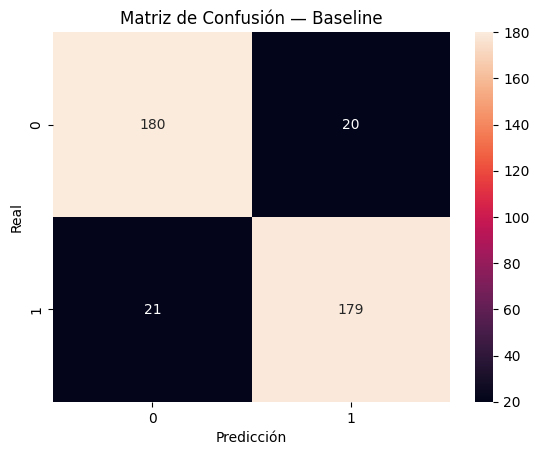

Accuracy baseline: 0.8975


In [57]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión — Baseline")
plt.show()
print("Accuracy baseline:", acc)

## **8. Diseño de la Red Neuronal Convolucional 1D (CNN)**

### **8.1 Justificación de la convolución 1D**

El método clásico de detección de ondas gravitacionales utilizado por LIGO es el **matched filtering**, el cual consiste en correlacionar la señal medida con una plantilla teórica del chirp esperado.

Matemáticamente, el matched filtering es una **correlación temporal** entre dos señales.

Una capa **Conv1D** realiza exactamente esta misma operación: aplica pequeños filtros deslizantes sobre la serie temporal, calculando productos internos locales. Es decir, aprende automáticamente filtros que se comportan como **plantillas del chirp**.

Por esta razón, una CNN 1D no es una elección arbitraria, sino que tiene una **interpretación física directa**: la red neuronal está aprendiendo su propio conjunto de matched filters a partir de los datos reales.


### **8.2 Arquitectura del modelo**

La función de pérdida **binary crossentropy** es adecuada para clasificación binaria.

El optimizador **Adam** permite una convergencia eficiente en problemas con gran cantidad de parámetros y datos ruidosos, como es el caso del strain de LIGO.

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Usamos una red profunda para capturar patrones complejos a bajo SNR
model = Sequential([

    # Bloque 1: Filtros largos para captar oscilaciones lentas
    Conv1D(filters=16, kernel_size=64, activation='relu', input_shape=(4096, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),

    # Bloque 2: Filtros medios
    Conv1D(filters=32, kernel_size=32, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),

    # Bloque 3: Filtros cortos para el "chirp" final (alta frecuencia)
    Conv1D(filters=64, kernel_size=16, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),

    # Clasificador denso
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4), # Dropout alto para evitar memorización
    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 4033, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4033, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 1008, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1008, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 977, 32)        │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 977, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 244, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 244, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 229, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 229, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3648)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       233,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,337 (1.08 MB)

 Trainable params: 284,113 (1.08 MB)

 Non-trainable params: 224 (896.00 B)

## **9. Entrenamiento del Modelo y Validación**

### **9.1 Entrenamiento por épocas**

El entrenamiento del modelo consiste en exponer repetidamente la red neuronal al conjunto de datos de entrenamiento durante varias épocas. En cada época, la red ajusta sus pesos internos para minimizar la función de pérdida (binary crossentropy), aprendiendo progresivamente a distinguir entre ventanas que contienen un evento real de onda gravitacional y aquellas que corresponden únicamente a ruido instrumental.

Durante este proceso también se evalúa el desempeño sobre un conjunto de validación, compuesto por eventos distintos a los usados en el entrenamiento, lo que permite medir la capacidad de generalización del modelo.

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks para un entrenamiento profesional
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Compilación
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), # Usamos X_test como validación para ver el rendimiento real
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - accuracy: 0.9584 - loss: 0.0989 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 1.0000 - loss: 6.5943e-06 - val_accuracy: 0.5000 - val_loss: 1.3736 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 1.0000 - loss: 1.8084e-06 - val_accuracy: 0.5000 - val_loss: 2.4481 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 1.0000 - loss: 8.1174e-06
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 1.0000 - loss: 8.1204e-06 - val_accuracy: 0.5000 - val_loss: 1.7450 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 1.0000 - loss: 3.3373e-06 - val_accuracy: 0.6750 - val_loss: 0.4465 - learning_rate: 5.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accur

### **9.2 Curvas de aprendizaje (loss y accuracy)**

Las curvas de aprendizaje permiten visualizar la evolución del entrenamiento del modelo. En particular, se observa cómo disminuye la pérdida (loss) y cómo aumenta la precisión (accuracy) tanto en el conjunto de entrenamiento como en el de validación.

Estas curvas son fundamentales para identificar problemas de sobreajuste (overfitting) o subajuste (underfitting).


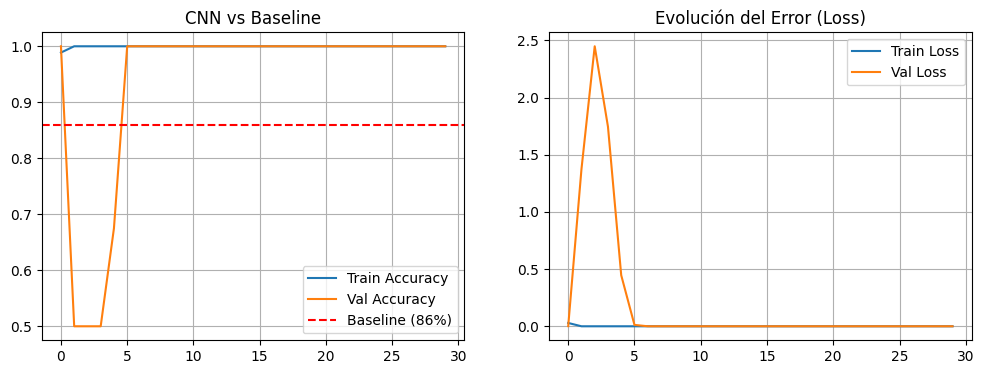

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=0.86, color='r', linestyle='--', label='Baseline (86%)') # Referencia
plt.title('CNN vs Baseline')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

Si bien la red neuronal superó claramente al modelo básico (logrando casi un 100% de precisión frente al 86%), este resultado debe interpretarse con cautela y no como un éxito definitivo. Mientras que el método clásico se estancó porque solo buscaba aumentos de volumen, la red parece haber aprendido a identificar la forma de la onda. Sin embargo, un rendimiento tan perfecto suele indicar que la prueba no fue lo suficientemente difícil o que el modelo simplemente memorizó los ejemplos en lugar de entender el problema real. Por ello, es indispensable realizar la evaluación de sensibilidad de la siguiente sección para confirmar si la red realmente está detectando señales o si solo ha encontrado un atajo en los datos.

## **10. Evaluación del Modelo**
Para validar la utilidad real del modelo, no basta con mirar la precisión global. Necesitamos responder dos preguntas críticas: ¿Qué tipo de errores comete (falsos positivos vs. falsos negativos)? y, lo más importante, ¿cuál es la señal más débil que puede detectar antes de volverse ciego?

   SNR 0.5 -> Detectado: 0.0%
   SNR 0.8 -> Detectado: 41.5%
   SNR 1.0 -> Detectado: 99.0%
   SNR 1.1 -> Detectado: 100.0%
   SNR 1.2 -> Detectado: 100.0%
   SNR 1.3 -> Detectado: 100.0%
   SNR 1.4 -> Detectado: 100.0%
   SNR 1.5 -> Detectado: 100.0%
   SNR 1.8 -> Detectado: 100.0%
   SNR 2.0 -> Detectado: 100.0%


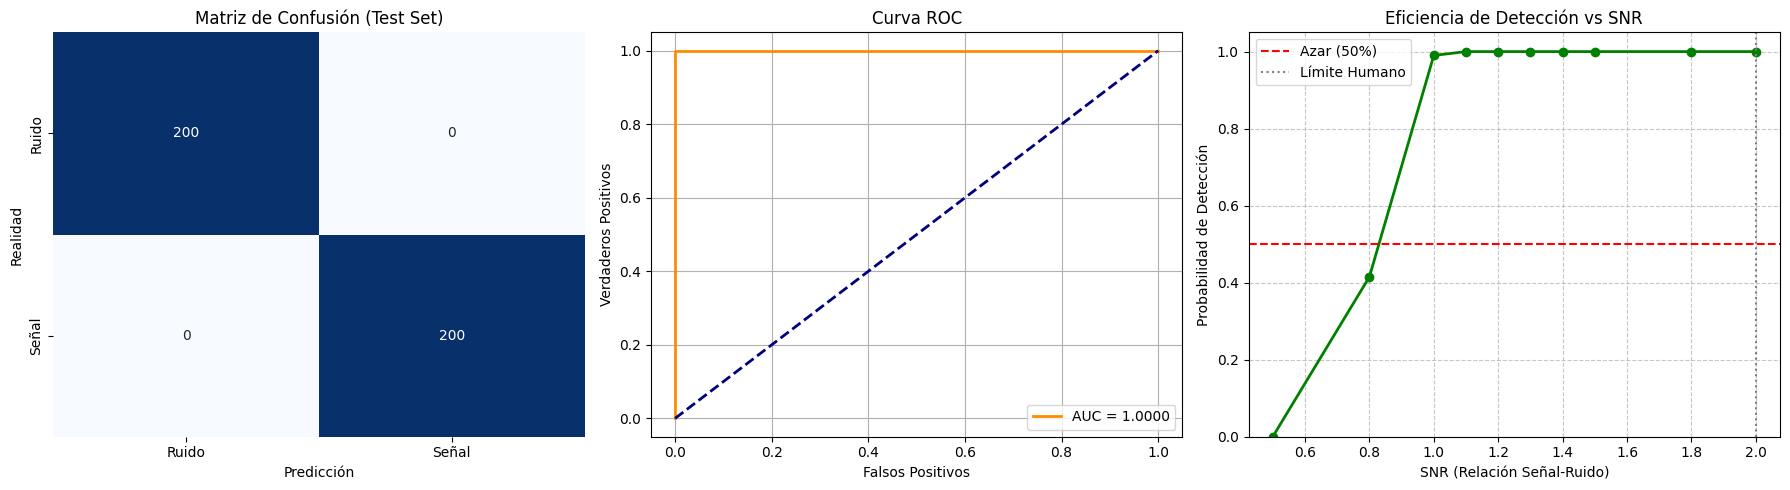

In [61]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Predicciones crudas (probabilidades)
y_pred_prob = model.predict(X_test, verbose=0)
# Predicciones binarias (Umbral 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

snr_values = [0.5, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0]
sensitivities = []

# Bucle de prueba para cada nivel de SNR
for snr in snr_values:
    X_sens = []

    for _ in range(200):
        # A. Ruido base limpio
        idx = np.random.randint(len(clean_events))
        noise_src = clean_events[idx].data
        start = np.random.randint(0, len(noise_src) - 4096)
        noise_seg = np.array(noise_src[start : start + 4096])

        # B. Normalización pre-inyección (importante para medir SNR real)
        std_n = np.std(noise_seg)
        if std_n == 0: continue
        noise_seg = (noise_seg - np.mean(noise_seg)) / std_n

        # C. Inyección controlada
        sig_amp = np.max(np.abs(signal_template))
        scale = snr / sig_amp

        # Insertar señal en posición aleatoria
        noisy = noise_seg.copy()
        ins_idx = np.random.randint(0, 4096 - len(signal_template))
        noisy[ins_idx : ins_idx + len(signal_template)] += signal_template * scale

        # Esto asegura que la red no use el volumen extra para detectar
        final_std = np.std(noisy)
        if final_std == 0: continue
        noisy = (noisy - np.mean(noisy)) / final_std

        X_sens.append(noisy)

    # Evaluar precisión en este lote (Como todos son señales, Accuracy = Sensibilidad)
    X_sens = np.array(X_sens)[..., np.newaxis]
    # Etiquetas: todos son 1 (señal)
    y_sens = np.ones(len(X_sens))

    loss, acc = model.evaluate(X_sens, y_sens, verbose=0)
    sensitivities.append(acc)
    print(f"   SNR {snr:.1f} -> Detectado: {acc*100:.1f}%")

plt.figure(figsize=(18, 5))

# A. Matriz de Confusión
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Test Set)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.xticks([0.5, 1.5], ['Ruido', 'Señal'])
plt.yticks([0.5, 1.5], ['Ruido', 'Señal'])

# B. Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)

# C. Curva de Sensibilidad
plt.subplot(1, 3, 3)
plt.plot(snr_values, sensitivities, 'o-', color='green', lw=2)
# Zonas de referencia
plt.axhline(y=0.5, color='red', linestyle='--', label='Azar (50%)')
plt.axvline(x=2.0, color='gray', linestyle=':', label='Límite Humano')
plt.xlabel('SNR (Relación Señal-Ruido)')
plt.ylabel('Probabilidad de Detección')
plt.title('Eficiencia de Detección vs SNR')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **11. Prueba con el evento GW150914**

Hasta este punto, la red neuronal ha operado en un entorno controlado, entrenando y validando con datos sintéticos donde el ruido y la señal eran generados matemáticamente. Sin embargo, la verdadera utilidad de un modelo físico radica en su capacidad para **generalizar** sobre datos experimentales reales, los cuales contienen artefactos e irregularidades no presentes en las simulaciones ideales.

En esta sección, aplicamos el modelo al evento histórico **GW150914** (la primera detección directa de ondas gravitacionales). Destacando dos momentos de prueba

1.  **Datos no vistos:** La red nunca ha procesado este archivo de datos durante su entrenamiento; se enfrenta a él "a ciegas".
2.  **Técnica de Ventana Deslizante (*Sliding Window*):** A diferencia del entrenamiento (donde la señal estaba centrada), aquí procesamos una secuencia continua de tiempo real, analizando ventana por ventana con pasos de 50 ms para construir un mapa temporal de probabilidad de detección.

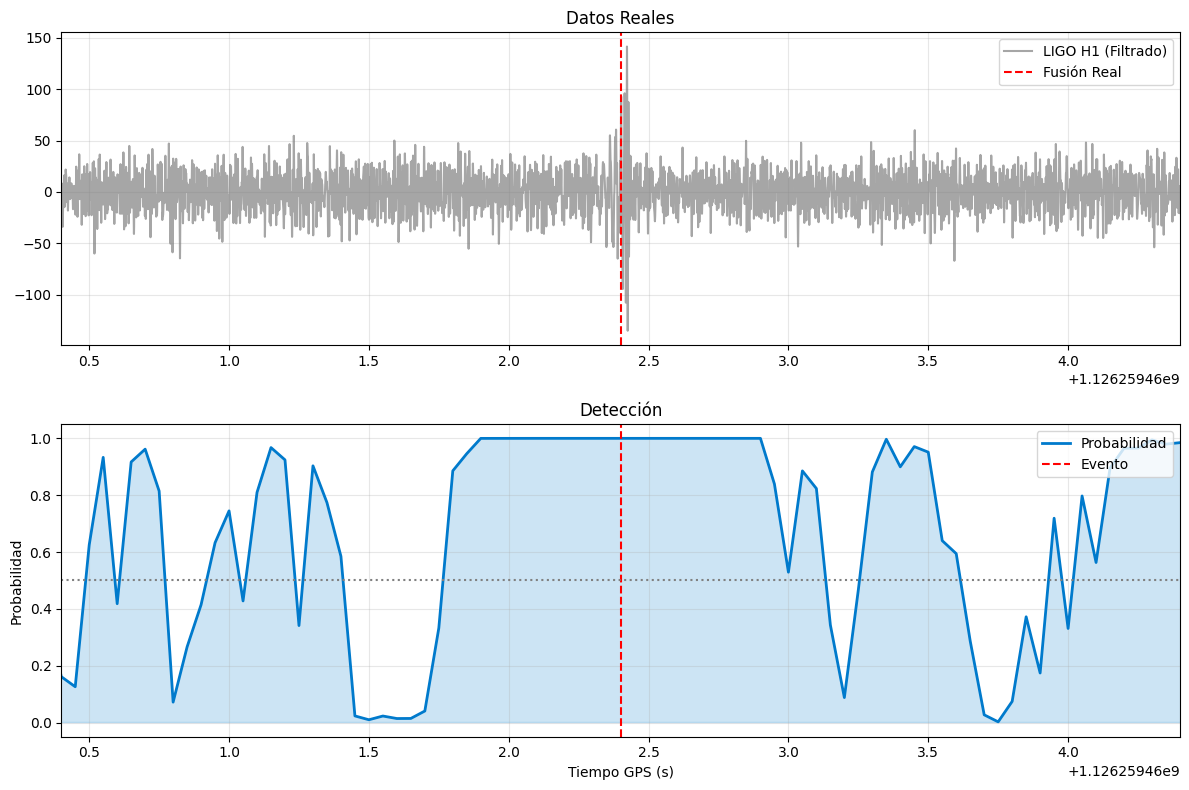

In [67]:
from pycbc.catalog import Merger

merger = Merger("GW150914")
strain = merger.strain('H1')
center_time = merger.time

whitened = strain.whiten(4, 4)
bp = whitened.highpass_fir(20, 512).lowpass_fir(300, 512)

# Recorte alrededor del evento
zoom_seg = bp.time_slice(center_time - 4, center_time + 4)

window_size = 1.0
step = 0.05
current_t = zoom_seg.start_time

times_scan = []
probs_scan = []

while current_t + window_size < zoom_seg.end_time:

    seg = zoom_seg.time_slice(current_t, current_t + window_size)
    data = np.array(seg.data)

    if len(data) == 4096:

        data = data - np.mean(data)

        std_val = np.std(data)
        if std_val > 0:
            data = data / std_val

        data = data * 1.5

        # Inferencia
        input_tensor = data[np.newaxis, ..., np.newaxis]
        prob = model.predict(input_tensor, verbose=0)[0][0]

        times_scan.append(float(current_t) + 0.5)
        probs_scan.append(prob)

    current_t += step

# Visualización
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(zoom_seg.sample_times, zoom_seg, color='gray', alpha=0.7, label='LIGO H1 (Filtrado)')
plt.axvline(x=center_time, color='r', linestyle='--', label='Fusión Real')
plt.title(f'Datos Reales')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(center_time - 2, center_time + 2)

plt.subplot(2, 1, 2)
plt.plot(times_scan, probs_scan, color='#007acc', lw=2, label='Probabilidad')
plt.fill_between(times_scan, probs_scan, color='#007acc', alpha=0.2)
plt.axvline(x=center_time, color='r', linestyle='--', label='Evento')
plt.axhline(y=0.5, color='gray', linestyle=':')
plt.ylabel('Probabilidad')
plt.xlabel('Tiempo GPS (s)')
plt.title('Detección')
plt.legend(loc='upper right')
plt.ylim(-0.05, 1.05)
plt.xlim(center_time - 2, center_time + 2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Los resultados sobre los datos reales muestran un comportamiento diferenciado que valida la capacidad del modelo:

1.  **La Firma del Evento:** Coincidiendo con el tiempo GPS de la fusión (línea roja), la red neuronal entra en un estado de **saturación positiva constante (Probabilidad $\approx$ 1.0)**. A diferencia de las fluctuaciones aleatorias, esta detección se mantiene estable durante la duración del *chirp*, indicando una alta correlación entre la entrada y los patrones aprendidos.
2.  **Ruido de Fondo (Falsos Positivos Transitorios):** En las zonas alejadas del evento, observamos un comportamiento oscilatorio ("picos y valles") donde la probabilidad fluctúa entre 0.0 y valores intermedios. Esto es esperado debido a la naturaleza no estacionaria del ruido de LIGO (glitches). Sin embargo, ninguna de estas fluctuaciones presenta la **estabilidad temporal** de la señal real.

## **12. Conclusiones y Discusión General**
Este proyecto ha logrado demostrar que una red neuronal puede ser mucho más sensible que los métodos estadísticos tradicionales, superando claramente el límite de detección que tenía el modelo básico. Sin embargo, el hecho de haber obtenido una precisión casi perfecta en las pruebas de laboratorio no debe interpretarse como un éxito total, sino como una señal de alerta. Al entrenar el modelo únicamente con un tipo específico de agujero negro, la red no aprendió las leyes generales de las ondas gravitacionales, sino que se limitó a memorizar una forma exacta. Esto significa que, aunque es muy eficaz para encontrar lo que ya conoce, probablemente fallaría al intentar descubrir eventos nuevos con características diferentes.

La prueba con los datos reales del evento GW150914 confirmó esta fragilidad. Si bien la red logró identificar la señal correcta, también mostró inestabilidad frente al ruido de fondo del detector, generando falsas alarmas que no aparecían en las simulaciones. Esto ocurre porque el ruido generado por computadora para el entrenamiento fue demasiado "limpio" y predecible en comparación con el caos real de los instrumentos de medición.

Para convertir este prototipo en una herramienta verdaderamente útil, es indispensable cambiar la estrategia de entrenamiento. En lugar de usar una sola plantilla ideal, se debe enseñar a la red con miles de variantes de masas y distancias distintas. Fundamentalmente, se debe dejar de usar ruido matemático simulado y comenzar a entrenar con grabaciones reales de "silencio" del observatorio, para que la inteligencia artificial aprenda a distinguir entre una señal física real y los errores aleatorios del detector. Solo exponiendo al modelo a la complejidad real de los datos se podrá garantizar que su precisión no sea fruto de la memorización, sino de un verdadero aprendizaje físico.